In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
plt.rcParams.update({'font.size': 8})

# 狗狼狐狸傻傻分不清楚

![Alt text](../images/animals.png)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import resnet

trident 0.7.1


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


Opencv version:4.1.2.
Pillow version:7.1.2.


In [3]:
#調用預訓練模型
#調用的模型會放置在 ~\.trident\models
resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3, 224, 224),
             classes=1000)

model file is already existing, donnot need download again.


C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'trident.layers.pytorch_layers.SoftMax' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


<p>傳回的ResNet50的型別是名為<em>ImageClassificationModel</em>的Model子類，ImageClassificationModel需要滿足<em>class_names(標籤清單)不為空</em>以及<em>preprocess_flow的清單內放置推論前需要的圖像處理函數</em>，這樣就可以直接調用infer_single_image(img,topk=1)來進行推論，當然，這邊的預訓練模型都已經幫大家設定好了，大家不需要做任何處理，但還是讓大家瞭解一下內部到底做了些甚麼，以ResNet50為例，他的preprocess_flow設定如下：</p>

<pre><code>
preprocess_flow=[resize((224,224),keep_aspect=True),#不扭曲比例縮放至224,224
    normalize(0,255), #像素除以255
    normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),#透過imagenet像素均值標準差再做一次正規化
    ]
</code></pre>

<p>至於infer_single_image(img,topk=1)這個函數中，img可以傳入的是一個<em>圖檔路徑</em>，或者是<em>PIL讀取的圖檔</em>，也可以是一個<em>圖檔向量(通道在後，RGB)</em></p>

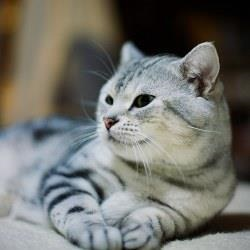

In [4]:
display.Image('../images/cat.jpg')

In [5]:
print(resnet50.infer_single_image('../images/cat.jpg',5))

{  n02124075	埃及猫: (285, 0.92575115),  n02128757	雪豹: (289, 0.04926293),  n02123045	虎斑猫: (281, 0.009550456),  n02123159	山猫: (282, 0.008158226),  n02127052	猞猁: (287, 0.003924414) }


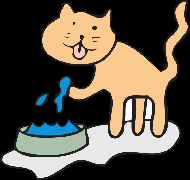

In [6]:
display.Image('../images/manka.png')

In [7]:
print(resnet50.infer_single_image('../images/manka.png',5))

{  n04423845	頂針: (855, 0.09333175),  n03595614	運動衫: (610, 0.08725003),  n04476259	托盤: (868, 0.08705924),  n07930864	杯子: (968, 0.04472515),  n15075141	衛生紙: (999, 0.035174392) }


In [8]:
data_provider=T.load_examples_data('animals')
data_provider.image_transform_funcs=[
                     RandomCenterCrop((224,224),scale_range=(0.8,2)),
                     #原比例隨機縮放(正確縮放比例再乘上0.8~1.2之間隨機數)中央裁切至224,224
                     RandomAdjustGamma(gamma_range=(0.6,1.5)),
                     #隨機調整圖片明暗gamma 0.6~1.4之間
                     RandomAdjustContrast(value_range=(0.6, 1.5)),
                     #隨機調整圖片對比度
                     RandomTransform(rotation_range=20,zoom_range=0.1,shift_range=0.02,shear_range=0.02,random_flip=0.2),
                     Normalize(0,255),#除以255
                     Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])] #透過imagenet像素均值標準差再做一次正規化
data_provider.minibatch_size=16

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:/Users/Allan/.trident/datasets/examples_animals
['cat', 'chipmunk', 'dog', 'fox', 'giraffe', 'guinea pig', 'hyena', 'reindeer', 'sikadeer', 'squirrel', 'weasel', 'wolf']
C:/Users/Allan/.trident/datasets/examples_animals/cat/*.*g
2766
C:/Users/Allan/.trident/datasets/examples_animals/chipmunk/*.*g
2829
C:/Users/Allan/.trident/datasets/examples_animals/dog/*.*g
3132
C:/Users/Allan/.trident/datasets/examples_animals/fox/*.*g
3191
C:/Users/Allan/.trident/datasets/examples_animals/giraffe/*.*g
3233
C:/Users/Allan/.trident/datasets/examples_animals/guinea pig/*.*g
2970
C:/Users/Allan/.trident/datasets/examples_animals/hyena/*.*g
2679
C:/Users/Allan/.trident/datasets/examples_animals/reindeer/*.*g
3158
C:/Users/Allan/.trident/datasets/examples_animals/sikadeer/*.*g
2857
C:/Users/Allan/.trident/datasets/examples_animals/squirrel/*.*g
2551
C:/Users/Allan/.trident/datasets/examples_

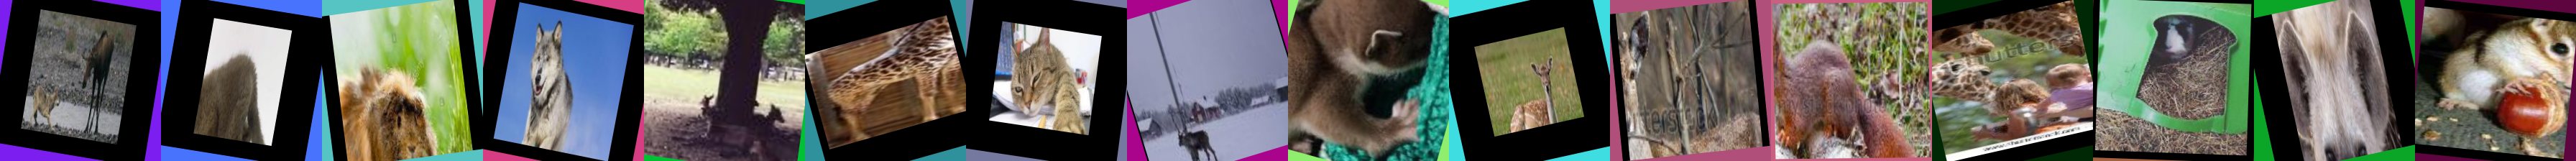

In [9]:

data,label=data_provider.next()
data_provider.preview_images()


In [10]:
finetune_resnet50=resnet.ResNet50(include_top=True,pretrained=True,input_shape=(3,224,224),classes=12)


model file is already existing, donnot need download again.


In [11]:
finetune_resnet50.summary()

--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
first_block.conv  [Conv2d]                         [None, 64, 112, 112]       [64, 3, 7, 7]                  9,408  236,015,360.0  
first_block.norm  [BatchNorm]                      [None, 64, 112, 112]       [64]                 [64]      128  2,395,904.0  
first_block  [Conv2d_Block]                        [None, 64, 112, 112]                                      0  0.0  
maxpool  [MaxPool2d]                               [None, 64, 56, 56]                                        0  0.0  
layer1.0.branch1.0.conv  [Conv2d]                  [None, 64, 56, 56]         [64, 64, 1, 1]                 4,096  25,686,976.0  
layer1.0.branch1.0.norm  [BatchNorm]               [None, 64, 56, 56]         [64]                 

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 3, 224, 224), ndim=4, name=input)
  (_outputs): { output: TensorSpec(shape=(None, 12), ndim=2, name=output) }
  (_targets): TensorSpec(shape=(None, 12), ndim=2, name=output)
)

In [12]:
finetune_resnet50.model.trainable=False
finetune_resnet50.summary()

23532620 parameters have set untrainable
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
first_block.conv  [Conv2d]                         [None, 64, 112, 112]       [64, 3, 7, 7]                  9,408  236,015,360.0  
first_block.norm  [BatchNorm]                      [None, 64, 112, 112]       [64]                 [64]      128  2,395,904.0  
first_block  [Conv2d_Block]                        [None, 64, 112, 112]                                      0  0.0  
maxpool  [MaxPool2d]                               [None, 64, 56, 56]                                        0  0.0  
layer1.0.branch1.0.conv  [Conv2d]                  [None, 64, 56, 56]         [64, 64, 1, 1]                 4,096  25,686,976.0  
layer1.0.branch1.0.norm  [BatchNorm]               [None, 

layer3.0.downsample  [Conv2d_Block]                [None, 1024, 14, 14]                                      0  0.0  
layer3.0  [ShortCut2d]                             [None, 1024, 14, 14]                                      0  0.0  
layer3.1.Identity  [Identity]                      [None, 1024, 14, 14]                                      0  0.0  
layer3.1.branch1.0.conv  [Conv2d]                  [None, 256, 14, 14]        [256, 1024, 1, 1]              262,144  102,760,252.0  
layer3.1.branch1.0.norm  [BatchNorm]               [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
layer3.1.branch1.0  [Conv2d_Block]                 [None, 256, 14, 14]                                       0  0.0  
layer3.1.branch1.1.conv  [Conv2d]                  [None, 256, 14, 14]        [256, 256, 3, 3]               589,824  231,210,812.0  
layer3.1.branch1.1.norm  [BatchNorm]               [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
layer3.1

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 3, 224, 224), ndim=4, name=input)
  (_outputs): { output: TensorSpec(shape=(None, 12), ndim=2, name=output) }
  (_targets): TensorSpec(shape=(None, 12), ndim=2, name=output)
)

In [13]:
finetune_resnet50.model.fc.trainable=True

finetune_resnet50.summary()

24588 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                    Output Shape               Weight               Bias      Param #   FLOPS #                  
first_block.conv  [Conv2d]                         [None, 64, 112, 112]       [64, 3, 7, 7]                  9,408  236,015,360.0  
first_block.norm  [BatchNorm]                      [None, 64, 112, 112]       [64]                 [64]      128  2,395,904.0  
first_block  [Conv2d_Block]                        [None, 64, 112, 112]                                      0  0.0  
maxpool  [MaxPool2d]                               [None, 64, 56, 56]                                        0  0.0  
layer1.0.branch1.0.conv  [Conv2d]                  [None, 64, 56, 56]         [64, 64, 1, 1]                 4,096  25,686,976.0  
layer1.0.branch1.0.norm  [BatchNorm]               [None, 64, 5

layer3.1.branch1.0.norm  [BatchNorm]               [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
layer3.1.branch1.0  [Conv2d_Block]                 [None, 256, 14, 14]                                       0  0.0  
layer3.1.branch1.1.conv  [Conv2d]                  [None, 256, 14, 14]        [256, 256, 3, 3]               589,824  231,210,812.0  
layer3.1.branch1.1.norm  [BatchNorm]               [None, 256, 14, 14]        [256]                [256]     512  150,332.0  
layer3.1.branch1.1  [Conv2d_Block]                 [None, 256, 14, 14]                                       0  0.0  
layer3.1.branch1.2.conv  [Conv2d]                  [None, 1024, 14, 14]       [1024, 256, 1, 1]              262,144  102,760,252.0  
layer3.1.branch1.2.norm  [BatchNorm]               [None, 1024, 14, 14]       [1024]               [1024]    2,048  601,916.0  
layer3.1.branch1.2  [Conv2d_Block]                 [None, 1024, 14, 14]                                      0  0.0 

ImageClassificationModel(
  (inputs): TensorSpec(shape=(None, 3, 224, 224), ndim=4, name=input)
  (_outputs): { output: TensorSpec(shape=(None, 12), ndim=2, name=output) }
  (_targets): TensorSpec(shape=(None, 12), ndim=2, name=output)
)

In [14]:
#自訂callbacks
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_batch_end(self, training_context):
        if training_context['steps']==200:
            training_context['current_model'].layer4.trainable=True #透過training_context切換模型指定層的trainable狀態
            
        elif training_context['steps']==1000:
            training_context['current_model'].layer3[5].trainable=True #透過training_context切換模型指定層的trainable狀態
            
        elif training_context['steps']==2000:
            training_context['current_model'].layer3[4].trainable=True #透過training_context切換模型指定層的trainable狀態
            
        if training_context['steps']>0 and training_context['steps']%1500==0:
            training_context['optimizer'].lr=training_context['optimizer'].lr*0.5
            #每訓練1500批次，學習速率降一半
    

In [15]:
finetune_resnet50=finetune_resnet50\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('min_max_norm')\
    .with_model_save_path('Models/finetune_resnet50.pth')\
    .with_automatic_mixed_precision_training()

#finetune_resnet50.load_model('Models/finetune_resnet50.pth')

CrossEntropyLoss( output, target) -> CrossEntropyLoss 
accuracy( output, target) -> accuracy 
top3_accuracy( output, target) -> top3_accuracy 
Automatic Mixed Precision:Turn On.


![Alt text](../images/animals_overview.jpg)

![Alt text](../images/cutmix.png)

In [16]:
finetune_resnet50=finetune_resnet50\
    .with_callbacks(CutMixCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(MixupCallback(alpha=1,loss_criterion=CrossEntropyLoss,loss_weight=0.2))\
    .with_callbacks(CustomCallback())

plan=TrainingPlan()\
    .add_training_item(finetune_resnet50)\
    .with_data_loader(data_provider)\
    .repeat_epochs(5)\
    .with_batch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .save_model_scheduling(100,unit='batch')\
    .display_loss_metric_curve_scheduling(200,unit='batch',imshow=True)


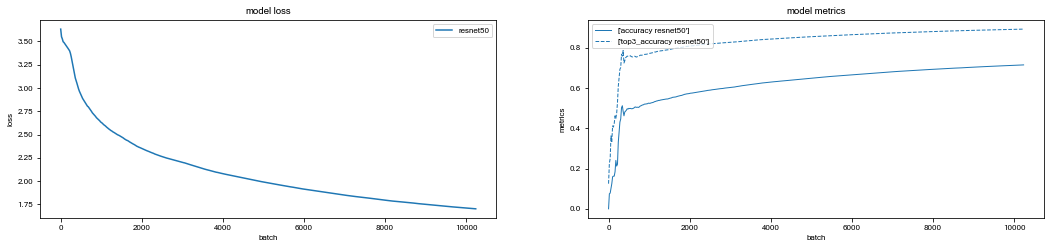

resnet50     Step: 43s21ms  | Loss: 1.709 | accuracy: 71.408% ,top3_accuracy: 89.272%  | learning rate: 1.563e-05  | epoch: 4  ( 1400/2214 )
resnet50     Step: 43s938ms | Loss: 1.708 | accuracy: 71.426% ,top3_accuracy: 89.282%  | learning rate: 1.563e-05  | epoch: 4  ( 1420/2214 )
resnet50     Step: 45s575ms | Loss: 1.707 | accuracy: 71.443% ,top3_accuracy: 89.292%  | learning rate: 1.563e-05  | epoch: 4  ( 1440/2214 )
resnet50     Step: 45s964ms | Loss: 1.707 | accuracy: 71.461% ,top3_accuracy: 89.301%  | learning rate: 1.563e-05  | epoch: 4  ( 1460/2214 )
resnet50     Step: 44s660ms | Loss: 1.706 | accuracy: 71.478% ,top3_accuracy: 89.311%  | learning rate: 1.563e-05  | epoch: 4  ( 1480/2214 )
resnet50     Step: 44s736ms | Loss: 1.705 | accuracy: 71.496% ,top3_accuracy: 89.321%  | learning rate: 1.563e-05  | epoch: 4  ( 1500/2214 )
resnet50     Step: 45s8ms   | Loss: 1.704 | accuracy: 71.513% ,top3_accuracy: 89.330%  | learning rate: 1.563e-05  | epoch: 4  ( 1520/2214 )
resnet50     

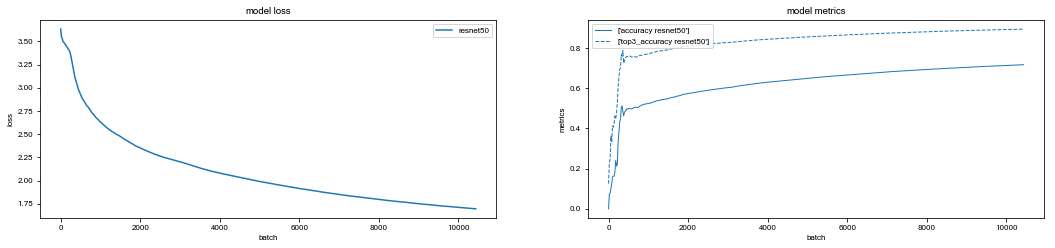

resnet50     Step: 45s349ms | Loss: 1.702 | accuracy: 71.585% ,top3_accuracy: 89.369%  | learning rate: 1.563e-05  | epoch: 4  ( 1600/2214 )
resnet50     Step: 43s296ms | Loss: 1.701 | accuracy: 71.601% ,top3_accuracy: 89.378%  | learning rate: 1.563e-05  | epoch: 4  ( 1620/2214 )
resnet50     Step: 46s128ms | Loss: 1.700 | accuracy: 71.618% ,top3_accuracy: 89.387%  | learning rate: 1.563e-05  | epoch: 4  ( 1640/2214 )
learning rate changed! ( form 1.563e-05 to 7.813e-06)
resnet50     Step: 38s204ms | Loss: 1.699 | accuracy: 71.634% ,top3_accuracy: 89.396%  | learning rate: 7.813e-06  | epoch: 4  ( 1660/2214 )
resnet50     Step: 36s943ms | Loss: 1.699 | accuracy: 71.650% ,top3_accuracy: 89.406%  | learning rate: 7.813e-06  | epoch: 4  ( 1680/2214 )
resnet50     Step: 37s380ms | Loss: 1.698 | accuracy: 71.666% ,top3_accuracy: 89.415%  | learning rate: 7.813e-06  | epoch: 4  ( 1700/2214 )
resnet50     Step: 36s522ms | Loss: 1.697 | accuracy: 71.682% ,top3_accuracy: 89.424%  | learning ra

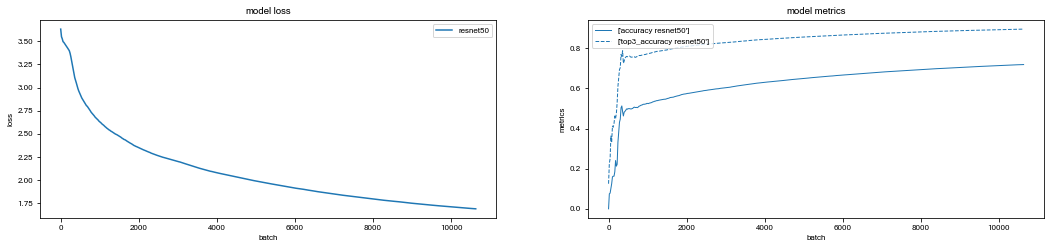

resnet50     Step: 35s355ms | Loss: 1.695 | accuracy: 71.744% ,top3_accuracy: 89.459%  | learning rate: 7.813e-06  | epoch: 4  ( 1800/2214 )
resnet50     Step: 34s460ms | Loss: 1.694 | accuracy: 71.759% ,top3_accuracy: 89.467%  | learning rate: 7.813e-06  | epoch: 4  ( 1820/2214 )
resnet50     Step: 35s499ms | Loss: 1.694 | accuracy: 71.774% ,top3_accuracy: 89.476%  | learning rate: 7.813e-06  | epoch: 4  ( 1840/2214 )
resnet50     Step: 37s564ms | Loss: 1.693 | accuracy: 71.789% ,top3_accuracy: 89.484%  | learning rate: 7.813e-06  | epoch: 4  ( 1860/2214 )
resnet50     Step: 35s978ms | Loss: 1.692 | accuracy: 71.805% ,top3_accuracy: 89.493%  | learning rate: 7.813e-06  | epoch: 4  ( 1880/2214 )
resnet50     Step: 35s861ms | Loss: 1.692 | accuracy: 71.820% ,top3_accuracy: 89.501%  | learning rate: 7.813e-06  | epoch: 4  ( 1900/2214 )
resnet50     Step: 41s530ms | Loss: 1.691 | accuracy: 71.835% ,top3_accuracy: 89.510%  | learning rate: 7.813e-06  | epoch: 4  ( 1920/2214 )
resnet50     

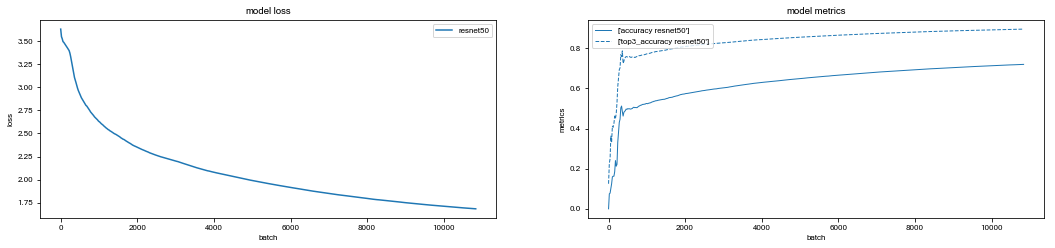

resnet50     Step: 37s373ms | Loss: 1.689 | accuracy: 71.893% ,top3_accuracy: 89.542%  | learning rate: 7.813e-06  | epoch: 4  ( 2000/2214 )
resnet50     Step: 38s820ms | Loss: 1.688 | accuracy: 71.908% ,top3_accuracy: 89.550%  | learning rate: 7.813e-06  | epoch: 4  ( 2020/2214 )
resnet50     Step: 39s347ms | Loss: 1.688 | accuracy: 71.923% ,top3_accuracy: 89.558%  | learning rate: 7.813e-06  | epoch: 4  ( 2040/2214 )
resnet50     Step: 39s856ms | Loss: 1.687 | accuracy: 71.939% ,top3_accuracy: 89.567%  | learning rate: 7.813e-06  | epoch: 4  ( 2060/2214 )
resnet50     Step: 36s308ms | Loss: 1.686 | accuracy: 71.955% ,top3_accuracy: 89.575%  | learning rate: 7.813e-06  | epoch: 4  ( 2080/2214 )
resnet50     Step: 42s530ms | Loss: 1.686 | accuracy: 71.971% ,top3_accuracy: 89.584%  | learning rate: 7.813e-06  | epoch: 4  ( 2100/2214 )
resnet50     Step: 39s471ms | Loss: 1.685 | accuracy: 71.986% ,top3_accuracy: 89.592%  | learning rate: 7.813e-06  | epoch: 4  ( 2120/2214 )
resnet50     

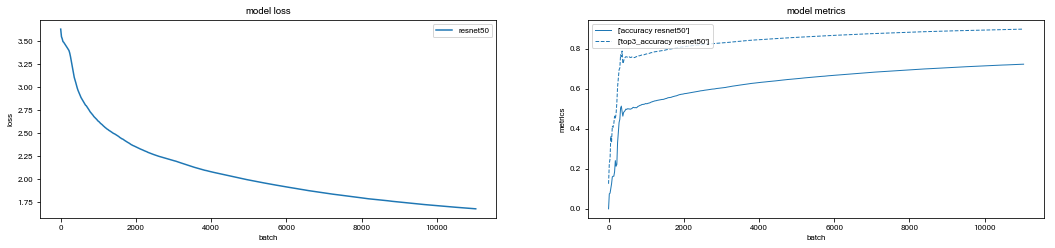

resnet50     Step: 42s675ms | Loss: 1.682 | accuracy: 72.050% ,top3_accuracy: 89.625%  | learning rate: 7.813e-06  | epoch: 4  ( 2200/2214 )


In [17]:
plan.start_now()


In [18]:
#finetune_resnet50.class_names=data_provider.class_names['en-us']

finetune_resnet50.class_names=['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']
print(finetune_resnet50.class_names)
finetune_resnet50.eval()

['貓 cat', '花栗鼠 chipmunk ', '狗 dog', '狐狸 fox', '長頸鹿 giraffe', '天竺鼠 guinea pig', '鬣狗 hyena', '馴鹿 reindeer', '梅花鹿 sikadeer', '松鼠 squirrel', '黃鼠狼 weasel', '狼 wolf']


模型訓練好後，我們利用infer_single_image來看一下預測效果，首先是那隻手繪的貓，這次模型答對了，機率高達99.7%

{ 貓 cat: (0, 0.7328393), 狗 dog: (2, 0.13956182), 馴鹿 reindeer: (7, 0.06509335), 松鼠 squirrel: (9, 0.02393762), 長頸鹿 giraffe: (4, 0.017221617) }


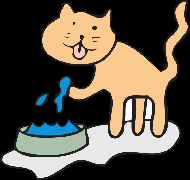

In [19]:
print(finetune_resnet50.infer_single_image('../images/manka.png',5))
display.Image('../images/manka.png')

那扮成美國隊長的貓呢?抱歉，模型還是答錯了，以為它是一隻鬣狗，不過各位可以發現模型對於沒把握，可能答錯這件事還是容易判斷的，你看他回答的最高機率只有23.6%%

{ 鬣狗 hyena: (6, 0.23656788), 貓 cat: (0, 0.17147492), 狗 dog: (2, 0.13320768) }


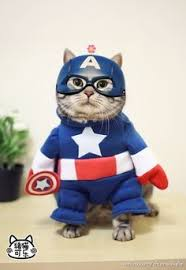

In [20]:
print(finetune_resnet50.infer_single_image('../images/captaincat.jpg',topk=3))
display.Image('../images/captaincat.jpg')

接下來是我當時故意設計的超難題，非洲十萬年前石壁壁畫，而這次模型也答對了。

{ 長頸鹿 giraffe: (4, 0.72088933), 鬣狗 hyena: (6, 0.07815234), 狼 wolf: (11, 0.07050541) }


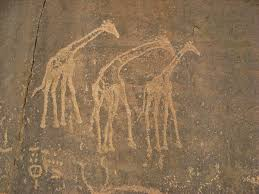

In [21]:
print(finetune_resnet50.infer_single_image('../images/africa.jpg',topk=3))
display.Image('../images/africa.jpg')



剪紙屬於高度的抽象畫與變形，即使是如此高度抽象的圖像，模型依然是正確的。

{ 貓 cat: (0, 0.4525128), 狼 wolf: (11, 0.4425614), 鬣狗 hyena: (6, 0.037862767) }


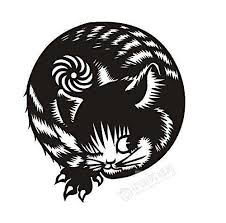

In [22]:
print(finetune_resnet50.infer_single_image('../images/paper.jpg',topk=3))
display.Image('../images/paper.jpg')

大家熟悉的海賊王喬巴，模型認為他是鬣狗的機率大於馴鹿。

{ 鬣狗 hyena: (6, 0.4313364), 馴鹿 reindeer: (7, 0.17562321), 狼 wolf: (11, 0.08204023) }


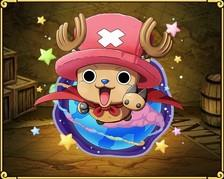

In [23]:
print(finetune_resnet50.infer_single_image('../images/joba.jpg',topk=3))
display.Image('../images/joba.jpg')

機器會認為它是狗還是長頸鹿呢?答案是機器能判斷它是一隻扮成長頸鹿的狗。

{ 長頸鹿 giraffe: (4, 0.43716627), 狗 dog: (2, 0.3275058), 鬣狗 hyena: (6, 0.05986794) }


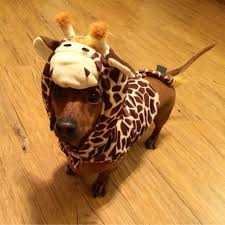

In [24]:
print(finetune_resnet50.infer_single_image('../images/fakegiraffe.jpg',topk=3))
display.Image('../images/fakegiraffe.jpg')

這個像拖把的物體其實是稀有的長毛天竺鼠，機器也答對了。

{ 天竺鼠 guinea pig: (5, 0.58068156), 狼 wolf: (11, 0.09732575), 狗 dog: (2, 0.077696435) }


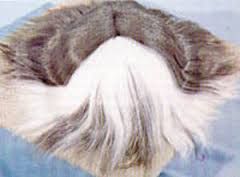

In [25]:
print(finetune_resnet50.infer_single_image('../images/longhair.jpg',topk=3))
display.Image('../images/longhair.jpg')#這是稀有品種長毛天竺鼠



但如果是最近爆紅的天竺鼠PUI PUI，很抱歉，機器的訓練集沒有類似的圖片，所以機器答錯了，他以為這些是一堆狗。

{ 狗 dog: (2, 0.30775186), 長頸鹿 giraffe: (4, 0.16873494), 貓 cat: (0, 0.13879761) }


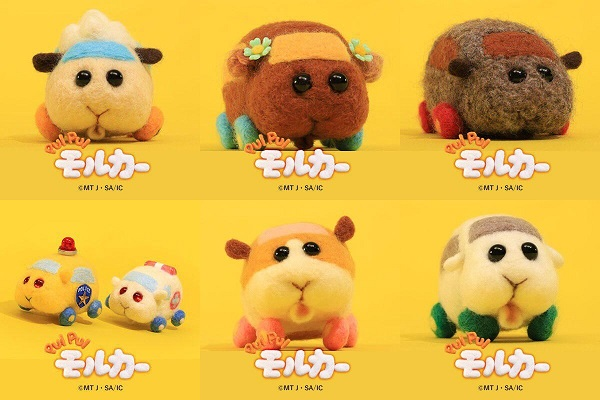

In [26]:
print(finetune_resnet50.infer_single_image('../images/pupu.jpg',topk=3))
display.Image('../images/pupu.jpg')